# 1. Install and import dependencies

## Installation

The first step is to install all the necessary libraries. 

1. Machine Learning libraries:

**- PyTorch:** For this project, I will use PyTorch, and as I am using an Apple silicon Mac, I will be running it on the MPS backend. 

**- Scikit-Learn:** This library is leveraged to split training and testing data and to quantify the precision or the likelihood of the speaker expressing a word on the real-time video feed.

2. Computer Vision libraries:

**- OpenCV** is an open-source Computer Vision library, in this project it is used to enable webcam activation.
**- MediaPipe Holistic** is used to track hand and face features by extracting keypoints.

3. Plotting library:

**- Matplotlib** is used for visual representation of data.

!pip install pytorch opencv-python mediapipe scikit-learn matplotlib numpy

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from IPython.display import display, clear_output

# 2. MediaPipe functions

In [2]:
# Holistic model to make detection
mp_holistic = mp.solutions.holistic 

# Drawing utilities to draw detection
mp_drawing = mp.solutions.drawing_utils 

# Function to make the detection
def mediapipe_detection(image, model):
    # Convert colors from BGR to RGB (needs to be RGB to make detection in MediaPipe)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    # To save space --> make unwriteable image
    image.flags.writeable = False  
    # Make prediction
    results = model.process(image) 
    # Convert back to writeable image
    image.flags.writeable = True  
    # Convert colors from BGR to RGB                 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

def draw_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(236,138,26), thickness=1, circle_radius=1),  # dot color (remember colors are in BGR )  
                             mp_drawing.DrawingSpec(color=(236,208,26), thickness=1, circle_radius=1)   # line color
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(186,52,25), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(236,103,26), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(0,153,0), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(51,255,51), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(255,255,0), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(255,255,102), thickness=2, circle_radius=2)
                             ) 

def keypoints_extraction(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    # face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)                # multiplied by 3 as it has x, y and z components
    left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(63)  
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(63)
    return np.concatenate([pose, left_hand, right_hand]) # no face

# 3. Folder setup for data collection

In [3]:
# Path for exported data, these are numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
#actions = np.array(['8'])

actions = np.array(['Hello','Thank you', 'I love you', 'How are you?', 'Nice to meet you!', 
                    "What's your name?", 'Deaf', 'Hearing', 'Hard of hearing', 'Goodbye', 'See you later','Sorry', 
                    'Please','Good', 'Fine', 'Bad','Excuse me', 'Good morning', 'Good night', 
                    'Hungry', 'Tired', 'Help', 'Busy', 'A','B','C','D','E','F','G','H','I','J',
                    'K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','1','2','3',
                    '4','5','7','8','10','11','12','13','14','15','20'])

# Number of videos collected per action
no_sequences = 60

# 30 frames each video
sequence_length = 30

# Folder start
start_folder = 30

# Create folders where data is stored
for action in actions:      # loop through actions
    for sequence in range(no_sequences):     # loop through videos (no_sequences,no_sequences+no_sequences): 
        try:    # just in case the directories are created already to avoid errors
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))  # a folder is created called 'MP_Data', then inside it another folder for each action, and within in action there will be a folder for each sequence/video
        except: # if the folder is created, skip making the directory
            pass

# 4. Data collection: Training and Testing data

In [160]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # Loop through actions
    for action in actions:
        # Loop through sequences/videos
        for sequence in range(no_sequences):  
        
            # Loop through video length
            for frame_num in range(sequence_length):
                # Read feed
                ret, frame = cap.read()
                # Make detections
                image, results = mediapipe_detection(frame, holistic)
                # Draw landmarks
                draw_landmarks(image, results)
                # Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), # x and y values of pixels where it is going to be displayed
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA) # font, font size, color in BGR, line width and line type
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,30), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('Webcam Feed', image)
                    cv2.waitKey(1000)    # wait half a second
                else: # if not in frame 0
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,30), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('Webcam Feed', image)
                
                # Extract and export keypoints
                keypoints = keypoints_extraction(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

# 5. Data preprocessing

In [4]:
label_map = {label:num for num, label in enumerate(actions)}
print(label_map)

# Load data
sequences, labels = [], []
for action in actions:
    sequence_list = [item for item in os.listdir(os.path.join(DATA_PATH, action)) if item.isdigit()]
    for sequence in np.array(sequence_list).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

# Convert to numpy arrays
X = np.array(sequences)
y = np.array(labels)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Create a dataset and split it
dataset = TensorDataset(X, y)
train_size = int(0.95 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

{'Hello': 0, 'Thank you': 1, 'I love you': 2, 'How are you?': 3, 'Nice to meet you!': 4, "What's your name?": 5, 'Deaf': 6, 'Hearing': 7, 'Hard of hearing': 8, 'Goodbye': 9, 'See you later': 10, 'Sorry': 11, 'Please': 12, 'Good': 13, 'Fine': 14, 'Bad': 15, 'Excuse me': 16, 'Good morning': 17, 'Good night': 18, 'Hungry': 19, 'Tired': 20, 'Help': 21, 'Busy': 22, 'A': 23, 'B': 24, 'C': 25, 'D': 26, 'E': 27, 'F': 28, 'G': 29, 'H': 30, 'I': 31, 'J': 32, 'K': 33, 'L': 34, 'M': 35, 'N': 36, 'O': 37, 'P': 38, 'Q': 39, 'R': 40, 'S': 41, 'T': 42, 'U': 43, 'V': 44, 'W': 45, 'X': 46, 'Y': 47, 'Z': 48, '1': 49, '2': 50, '3': 51, '4': 52, '5': 53, '7': 54, '8': 55, '10': 56, '11': 57, '12': 58, '13': 59, '14': 60, '15': 61, '20': 62}


# 6. Neural Network

## Model architecture definition

In [11]:
# Define the model
class SignLanguageModel(nn.Module):
    def __init__(self):
        super(SignLanguageModel, self).__init__()
        self.gru1 = nn.GRU(258, 128, batch_first=True, bidirectional=True)
        self.bn1 = nn.BatchNorm1d(30)
        self.dropout1 = nn.Dropout(0.3)
        
        self.gru2 = nn.GRU(256, 128, batch_first=True, bidirectional=True)
        self.bn2 = nn.BatchNorm1d(30)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, actions.shape[0])
        
    def forward(self, x):
        x, _ = self.gru1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        
        x, _ = self.gru2(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        
        x = x[:, -1, :]  # take the last time step
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training and Evaluation

MPS device detected. Running on MPS.
Epoch 1/100, Train Loss: 4.0805, Test Loss: 4.0208, Train Acc: 1.31, Test Acc: 3.37


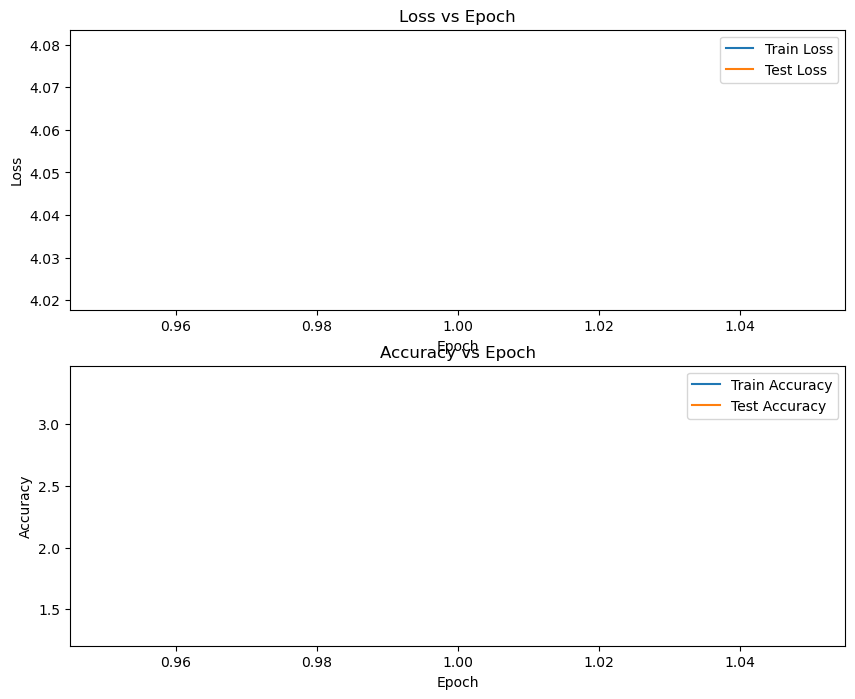

Epoch 2/100, Train Loss: 3.7936, Test Loss: 3.6030, Train Acc: 3.99, Test Acc: 3.37
Epoch 3/100, Train Loss: 3.3377, Test Loss: 3.1841, Train Acc: 6.90, Test Acc: 3.37
Epoch 4/100, Train Loss: 3.1097, Test Loss: 2.9233, Train Acc: 8.27, Test Acc: 6.74
Epoch 5/100, Train Loss: 3.0126, Test Loss: 2.8204, Train Acc: 10.17, Test Acc: 10.11
Epoch 6/100, Train Loss: 2.8121, Test Loss: 2.6568, Train Acc: 14.99, Test Acc: 10.11
Epoch 7/100, Train Loss: 2.6470, Test Loss: 2.3901, Train Acc: 17.79, Test Acc: 31.46
Epoch 8/100, Train Loss: 2.3416, Test Loss: 2.1489, Train Acc: 26.65, Test Acc: 33.71
Epoch 9/100, Train Loss: 2.0893, Test Loss: 1.9788, Train Acc: 32.96, Test Acc: 39.33
Epoch 10/100, Train Loss: 1.9030, Test Loss: 1.7271, Train Acc: 36.05, Test Acc: 44.94
Epoch 11/100, Train Loss: 1.4901, Test Loss: 1.3872, Train Acc: 51.04, Test Acc: 55.06
Epoch 12/100, Train Loss: 1.3577, Test Loss: 1.4100, Train Acc: 52.71, Test Acc: 55.06
Epoch 13/100, Train Loss: 1.3025, Test Loss: 1.3279, Trai

In [12]:
# Set device to CUDA or MPS
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA device detected. Running on CUDA.")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("MPS device detected. Running on MPS.")
else:
    device = torch.device('cpu')
    print("No GPU detected. Running on CPU.")

# Initialize the model, loss function, optimizer, and scheduler
model = SignLanguageModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

# Enable interactive mode in matplotlib
plt.ion()

# Create figures and axes for live plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

num_epochs = 100
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0.0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
    
    scheduler.step()
    train_losses.append(running_loss / len(train_loader.dataset))
    train_accuracies.append(100 * correct / len(train_loader.dataset))
    
    model.eval()
    test_loss, correct = 0.0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
    
    test_losses.append(test_loss / len(test_loader.dataset))
    test_accuracies.append(100 * correct / len(test_loader.dataset))
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}, Test Acc: {test_accuracies[-1]:.2f}')

    # Update plots
    ax1.clear()
    ax1.plot(range(1, epoch+2), train_losses, label='Train Loss')
    ax1.plot(range(1, epoch+2), test_losses, label='Test Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Loss vs Epoch')
    
    ax2.clear()
    ax2.plot(range(1, epoch+2), train_accuracies, label='Train Accuracy')
    ax2.plot(range(1, epoch+2), test_accuracies, label='Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.set_title('Accuracy vs Epoch')
    
    plt.pause(0.1)

# Disable interactive mode and show final plot
plt.ioff()
plt.show()

# Improved prediction example
model.eval()
with torch.no_grad():
    for i in range(5):  # Show 5 examples
        X_batch, y_batch = next(iter(test_loader))
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        print(f'Predicted: {actions[predicted[i]]}, Actual: {actions[y_batch[i]]}')

In [5]:
# Define the model
class SignLanguageModel(nn.Module):
    def __init__(self):
        super(SignLanguageModel, self).__init__()
        self.lstm1 = nn.LSTM(258, 128, batch_first=True, bidirectional=True)
        self.bn1 = nn.BatchNorm1d(30)
        self.dropout1 = nn.Dropout(0.3)
        
        self.gru1 = nn.GRU(256, 128, batch_first=True, bidirectional=True)
        self.bn2 = nn.BatchNorm1d(30)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, actions.shape[0])
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        
        x, _ = self.gru1(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        
        x = x[:, -1, :]  # take the last time step
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Definite version

In [6]:
# Define the model
class SignLanguageModel(nn.Module):
    def __init__(self):
        super(SignLanguageModel, self).__init__()
        self.lstm1 = nn.LSTM(258, 128, batch_first=True, bidirectional=True)
        self.bn1 = nn.BatchNorm1d(30)
        self.dropout1 = nn.Dropout(0.3)
        
        self.gru1 = nn.GRU(256, 128, batch_first=True, bidirectional=True)
        self.bn2 = nn.BatchNorm1d(30)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, actions.shape[0])
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        
        x, _ = self.gru1(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        
        x = x[:, -1, :]  # take the last time step
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Set device to CUDA or MPS
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA device detected. Running on CUDA.")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("MPS device detected. Running on MPS.")
else:
    device = torch.device('cpu')
    print("No GPU detected. Running on CPU.")

MPS device detected. Running on MPS.


Last epoch 80, Train Loss: 0.0591, Test Loss: 0.2097, Train Acc: 97.99, Test Acc: 94.18, Overall Time: 2151.98 sec


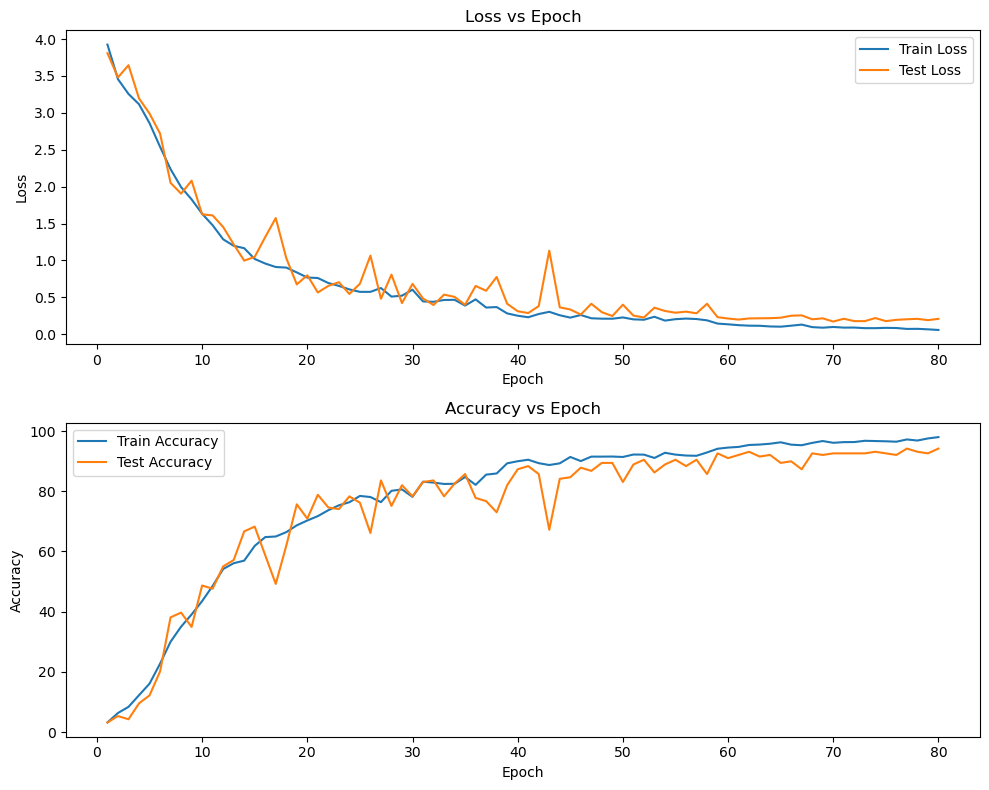

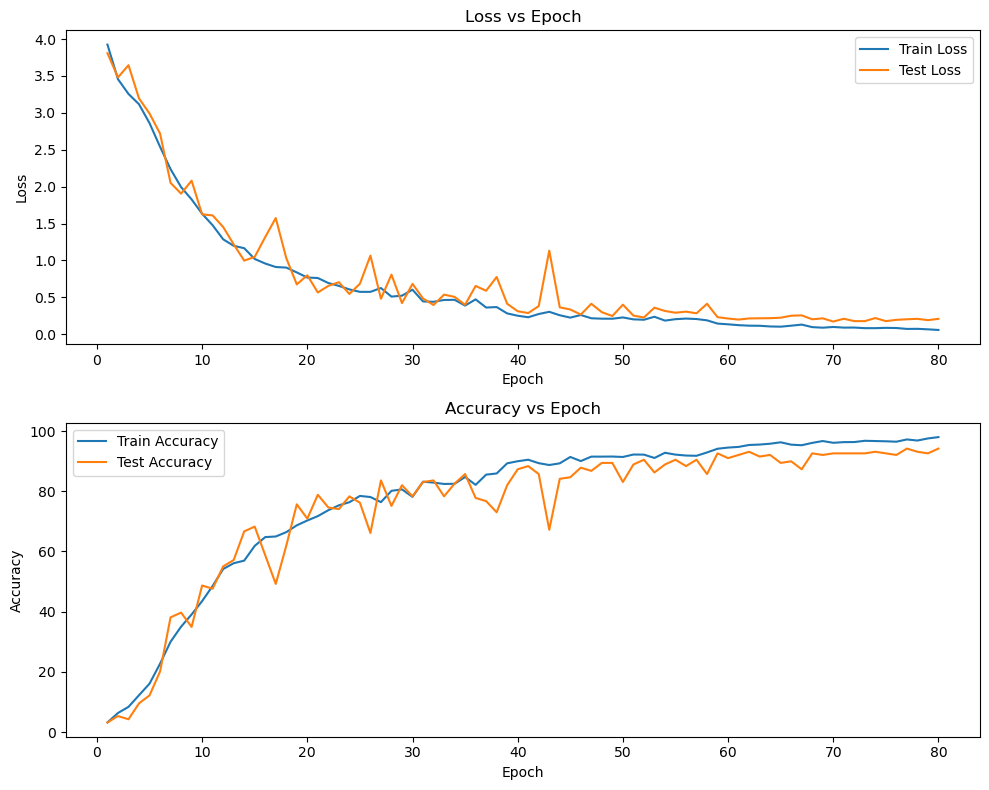

Predicted: 15, Actual: 15
Predicted: Thank you, Actual: Thank you
Predicted: W, Actual: W
Predicted: K, Actual: K
Predicted: What's your name?, Actual: What's your name?


In [5]:
# Set device to CUDA or MPS
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA device detected. Running on CUDA.")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("MPS device detected. Running on MPS.")
else:
    device = torch.device('cpu')
    print("No GPU detected. Running on CPU.")

# Initialize the model, loss function, optimizer, and scheduler
model = SignLanguageModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Reduced learning rate
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Optimize data loading
num_workers = 10  # Adjust based on your CPU cores
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=num_workers, pin_memory=True)

# Enable interactive mode in matplotlib
plt.ion()

# Create figures and axes for live plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

num_epochs = 80
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

start_time_total = time.time()  # Start the overall timer

for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start the epoch timer
    model.train()
    running_loss, correct = 0.0, 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
    
    train_losses.append(running_loss / len(train_loader.dataset))
    train_accuracies.append(100 * correct / len(train_loader.dataset))
    
    model.eval()
    test_loss, correct = 0.0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
    
    test_losses.append(test_loss / len(test_loader.dataset))
    test_accuracies.append(100 * correct / len(test_loader.dataset))
    
    scheduler.step(test_losses[-1])  # Step the scheduler with the test loss
    
    epoch_time = time.time() - epoch_start_time  # Time taken for the epoch
    overall_time = time.time() - start_time_total  # Overall time taken
    
    # Print epoch results with timing information
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}, Test Acc: {test_accuracies[-1]:.2f}, Epoch Time: {epoch_time:.2f} sec, Overall Time: {overall_time:.2f} sec')

    # Clear previous plot and update
    ax1.clear()
    ax1.plot(range(1, epoch+2), train_losses, label='Train Loss')
    ax1.plot(range(1, epoch+2), test_losses, label='Test Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Loss vs Epoch')
    
    ax2.clear()
    ax2.plot(range(1, epoch+2), train_accuracies, label='Train Accuracy')
    ax2.plot(range(1, epoch+2), test_accuracies, label='Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.set_title('Accuracy vs Epoch')
    
    plt.tight_layout()
    display(fig)
    plt.pause(0.1)
    clear_output(wait=True)

# Disable interactive mode and show final plot
plt.ioff()

print(f'Last epoch {num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}, Test Acc: {test_accuracies[-1]:.2f}, Overall Time: {overall_time:.2f} sec')

fig1, (ax3, ax4) = plt.subplots(2, 1, figsize=(10, 8))

ax3.plot(range(1, epoch+2), train_losses, label='Train Loss')
ax3.plot(range(1, epoch+2), test_losses, label='Test Loss')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.legend()
ax3.set_title('Loss vs Epoch')

ax4.plot(range(1, epoch+2), train_accuracies, label='Train Accuracy')
ax4.plot(range(1, epoch+2), test_accuracies, label='Test Accuracy')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy')
ax4.legend()
ax4.set_title('Accuracy vs Epoch')

plt.tight_layout()
display(fig1)
plt.show()

# Improved prediction example
model.eval()
with torch.no_grad():
    for i in range(5):  # Show 5 examples
        X_batch, y_batch = next(iter(test_loader))
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        print(f'Predicted: {actions[predicted[i]]}, Actual: {actions[y_batch[i]]}')

In [173]:
# Improved prediction example
model.eval()
with torch.no_grad():
    for i in range(16):  # Show 5 examples
        X_batch, y_batch = next(iter(test_loader))
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        print(f'Predicted: {actions[predicted[i]]}, Actual: {actions[y_batch[i]]}')

RuntimeError: Placeholder storage has not been allocated on MPS device!

In [7]:
# Save the model weights
torch.save(model.state_dict(), 'sign_language_model_weights_v4_80e_ds4_v2.pth')
print("Model weights saved successfully.")

# To load the weights
#model = SignLanguageModel()
#model.load_state_dict(torch.load('sign_language_model_weights.pth'))
#model.to(device)
#model.eval()

Model weights saved successfully.


In [165]:
train_accuracies[-1]

98.63547758284601

In [166]:
train_accuracies

[2.506265664160401,
 3.78724589250905,
 6.432748538011696,
 10.247841826789195,
 15.845168476747425,
 19.910888331940964,
 23.78167641325536,
 29.072681704260653,
 33.751044277360066,
 38.485101642996376,
 42.968532442216656,
 48.148148148148145,
 54.30242272347535,
 57.170704539125595,
 61.48705096073517,
 62.76803118908382,
 64.60595934280146,
 68.114731272626,
 69.14508493455862,
 68.97800055694792,
 73.60066833751044,
 73.15510999721526,
 75.04873294346979,
 75.46644388749652,
 78.27903091060986,
 78.69674185463658,
 79.97772208298524,
 79.75494291283765,
 81.17516012252854,
 81.78780284043442,
 81.28654970760233,
 82.73461431356168,
 83.5978835978836,
 82.67891952102478,
 83.98774714564188,
 83.84851016429964,
 85.96491228070175,
 86.99526594263436,
 85.71428571428571,
 85.43581175160122,
 88.02561960456697,
 86.57755499860762,
 87.16235032024505,
 86.99526594263436,
 88.13700918964076,
 91.97994987468671,
 92.92676134781398,
 93.03815093288777,
 91.95210247841827,
 93.76218323586

In [167]:
test_accuracies

[3.7037037037037037,
 4.761904761904762,
 8.994708994708995,
 13.756613756613756,
 19.047619047619047,
 21.693121693121693,
 33.86243386243386,
 34.92063492063492,
 43.91534391534392,
 46.03174603174603,
 26.984126984126984,
 51.851851851851855,
 60.84656084656085,
 55.55555555555556,
 65.60846560846561,
 46.03174603174603,
 67.19576719576719,
 55.55555555555556,
 76.71957671957672,
 71.42857142857143,
 71.95767195767196,
 72.48677248677248,
 74.60317460317461,
 82.53968253968254,
 78.3068783068783,
 75.66137566137566,
 80.42328042328042,
 79.36507936507937,
 76.71957671957672,
 84.65608465608466,
 80.95238095238095,
 75.13227513227513,
 81.48148148148148,
 80.42328042328042,
 83.5978835978836,
 84.12698412698413,
 79.8941798941799,
 83.06878306878306,
 84.12698412698413,
 85.71428571428571,
 86.24338624338624,
 84.12698412698413,
 84.65608465608466,
 79.8941798941799,
 86.24338624338624,
 88.88888888888889,
 87.3015873015873,
 86.24338624338624,
 91.53439153439153,
 86.77248677248677,

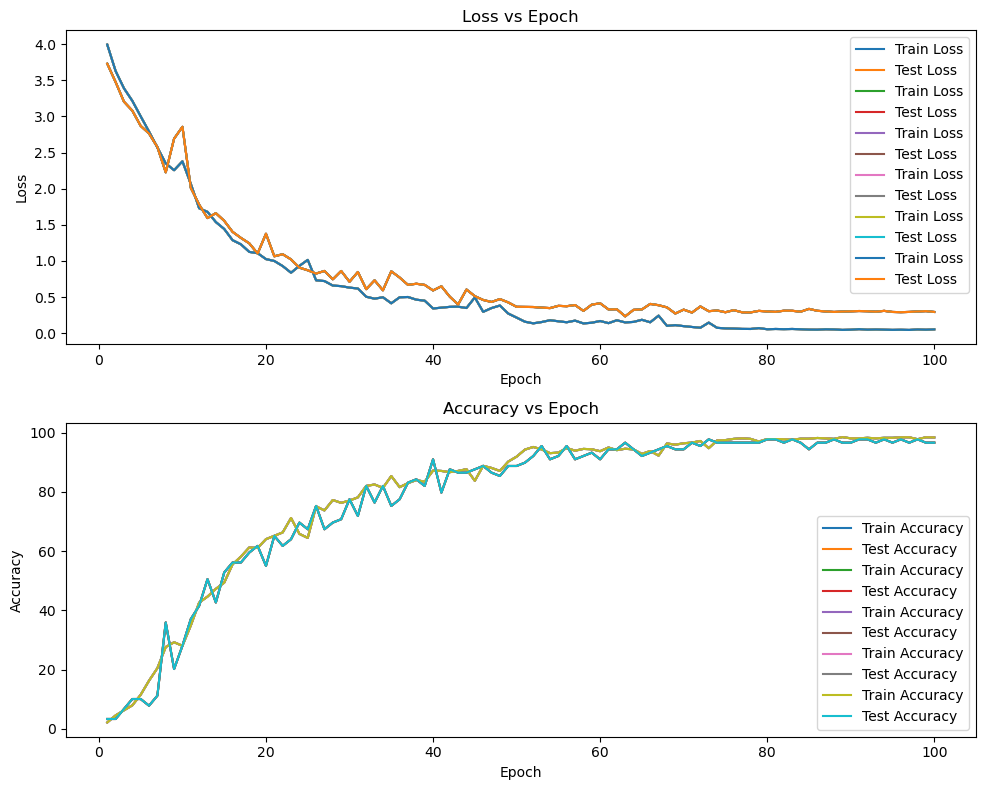

In [36]:
ax1.plot(range(1, epoch+2), train_losses, label='Train Loss')
ax1.plot(range(1, epoch+2), test_losses, label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss vs Epoch')

ax2.plot(range(1, epoch+2), train_accuracies, label='Train Accuracy')
ax2.plot(range(1, epoch+2), test_accuracies, label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title('Accuracy vs Epoch')

plt.tight_layout()
display(fig)

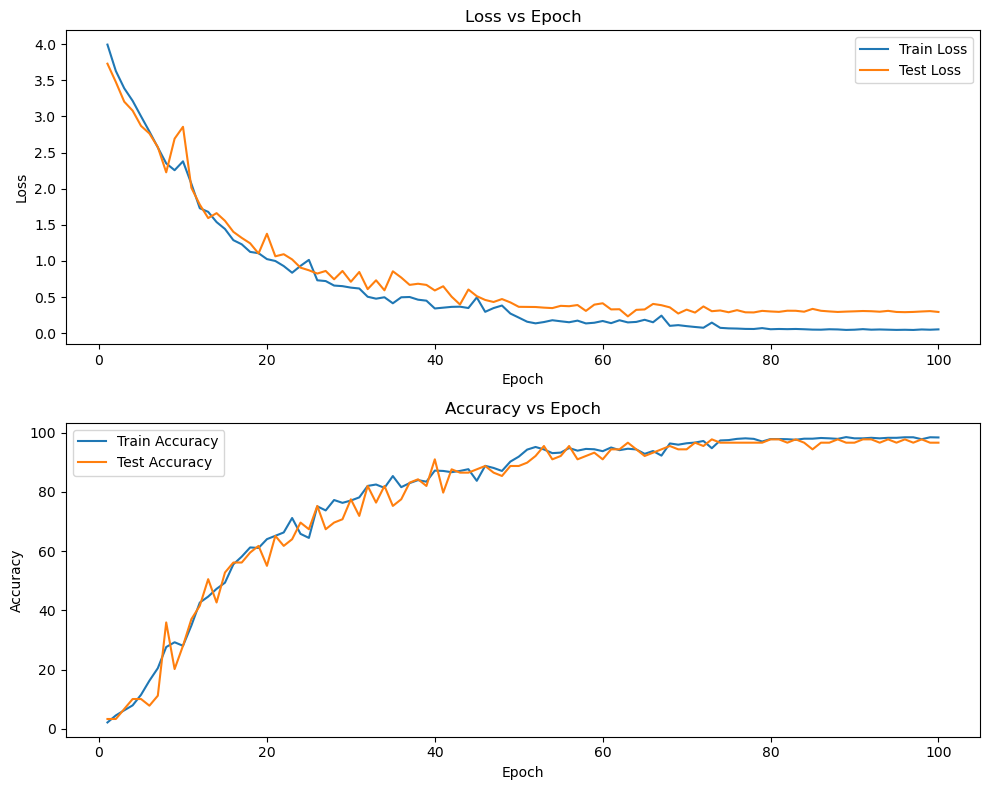

In [38]:
fig1, (ax3, ax4) = plt.subplots(2, 1, figsize=(10, 8))

ax3.plot(range(1, epoch+2), train_losses, label='Train Loss')
ax3.plot(range(1, epoch+2), test_losses, label='Test Loss')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.legend()
ax3.set_title('Loss vs Epoch')

ax4.plot(range(1, epoch+2), train_accuracies, label='Train Accuracy')
ax4.plot(range(1, epoch+2), test_accuracies, label='Test Accuracy')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy')
ax4.legend()
ax4.set_title('Accuracy vs Epoch')

plt.tight_layout()
display(fig1)

## Predictions

In [32]:
# Improved prediction example
model.eval()
with torch.no_grad():
    for i in range(16):  # Show 5 examples
        X_batch, y_batch = next(iter(test_loader))
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        print(f'Predicted: {actions[predicted[i]]}, Actual: {actions[y_batch[i]]}')

Predicted: D, Actual: D
Predicted: R, Actual: R
Predicted: How are you?, Actual: How are you?
Predicted: J, Actual: J
Predicted: Help, Actual: Help
Predicted: Please, Actual: Please
Predicted: R, Actual: R
Predicted: A, Actual: A
Predicted: Help, Actual: Help
Predicted: Busy, Actual: Busy
Predicted: R, Actual: R
Predicted: Q, Actual: Q
Predicted: I, Actual: I
Predicted: H, Actual: H
Predicted: B, Actual: B
Predicted: Hard of hearing, Actual: Hard of hearing


# 7. Live Test

### Improtant added the following to improve predictions

	1.Increased Threshold:
    	•	The threshold for displaying the predicted action has been increased to 0.9 for higher confidence.
	2. Adjusted MediaPipe Confidence Levels:
    	•	min_detection_confidence and min_tracking_confidence have been increased to 0.85 to ensure more reliable keypoint detections.
	3. Smoothing Predictions:
    	•	A simple smoothing technique is implemented by using the most common prediction over the last 10 frames.
    	•	Only if the most common prediction appears more than 5 times in the last 10 frames and its confidence is above the threshold, it will be displayed.

In [8]:
#import cv2
#import numpy as np
#import torch
#
## Set device to CUDA or MPS
#if torch.cuda.is_available():
#    device = torch.device('cuda')
#    print("CUDA device detected. Running on CUDA.")
#elif torch.backends.mps.is_available():
#    device = torch.device('mps')
#    print("MPS device detected. Running on MPS.")
#else:
#    device = torch.device('cpu')
#    print("No GPU detected. Running on CPU.")
#
## Define the actions array as in your training
#actions = np.array(['Hello','Thank you', 'I love you', 'How are you?', 'Nice to meet you!', 
#                    "What's your name?", 'Deaf', 'Hard of hearing', 'Goodbye','Sorry', 'Please',
#                    'Good', 'Fine', 'Bad','Excuse me', 'Good morning', 'Good night', 'Hungry', 
#                    'Tired', 'Help', 'Busy', 'A','B','C','D','E','F','G','H','I','J','K','L','M',
#                    'N','O','P','Q','R','S','T','U','V','W','X','Y','Z','1','2','3','4','5','10',
#                    '11','12','13','14','15','20'])
#
# Load the model
model = SignLanguageModel()
model.load_state_dict(torch.load('sign_language_model_weights_v4_80e_ds4.pth'))
model.to(device)
model.eval()

predictions = []
sequence = []
threshold = 0.95  # Increased threshold for higher confidence

cap = cv2.VideoCapture(0)
# Set mediapipe model
mp_holistic = mp.solutions.holistic 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        # Draw landmarks
        draw_landmarks(image, results)
        
        # Prediction logic
        keypoints = keypoints_extraction(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            input_data = np.expand_dims(sequence, axis=0)
            input_data = torch.tensor(input_data, dtype=torch.float32).to(device)
            
            with torch.no_grad():
                res = model(input_data)
                res = res.cpu().numpy()[0]
                predictions.append(np.argmax(res))
                
                # Implementing simple smoothing
                if len(predictions) >= 10:
                    most_common_pred = np.bincount(predictions[-10:]).argmax()
                    if np.bincount(predictions[-10:])[most_common_pred] > 5 and res[most_common_pred] > threshold:
                        sentence = str(actions[most_common_pred])
                        cv2.putText(image, sentence, (10, 30), 
                                    cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('Webcam Feed', image)
        
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

2024-07-10 21:02:56.727 python[72762:2449567] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
